In [138]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
from typing import List, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

In [139]:
def entropy_function(class_count: "Counter", num_samples: int) -> float:
    """
    Returns entropy of set S, defined as:
        class count -> {classA: k, classB: l, classC: m}  k,l,m ∈ N
        number of samples -> k + l + m

    Entropy of set S (impurity) : low entropy => low impurity
    I(S) = −Σ{ [i] -> [n] : { pi * ln(pi) } },
    where:
        |S| -> num_samples
        pi  -> percentage of such samples in S
    """

    if num_samples == 0:
        return 0.0

    entropy = 0.0
    for count in class_count.values():
        pi = count / num_samples
        entropy -= pi * math.log(pi)

    return entropy

In [140]:
class Group:
    """
    Group represents a set of samples, defined as:
        group_classes -> {classA: k, classB: l, classC: m}  k,l,m ∈ N
        members       -> matrix[n][4] representing samples      n ∈ N
        entropy       -> I(S)
    """
    def __init__(self, group_classes: np.ndarray, members: np.ndarray) -> None:
        if len(group_classes) != len(members):
            raise ValueError("Group classes and members must have the same length")

        self.group_classes_count: Counter = Counter(group_classes.tolist())
        self.group_classes: np.ndarray = group_classes
        self.members: np.ndarray = members
        self.entropy: float = self.group_entropy()

    def __len__(self) -> int:
        return sum(self.group_classes_count.values())

    def group_entropy(self) -> float:
        return entropy_function(self.group_classes_count, self.__len__())

In [141]:
class Node:
    """
    Node represents a single sample of training data, eg. vector[4] and its class
    """
    def __init__(self, split_feature: Optional[int]=None, split_value: Optional[float]=None, depth: int=0, child_node_a: Optional["Node"]=None, child_node_b: Optional["Node"]=None, sample_class: Optional[int]= None, sample_vector: Optional[np.ndarray]= None):
        self.split_feature: Optional[int] = split_feature
        self.split_value: Optional[float] = split_value
        self.depth: int = depth
        self.child_node_a: Optional["Node"] = child_node_a
        self.child_node_b: Optional["Node"] = child_node_b
        self.sample_class: Optional[int] = sample_class
        self.sample_vector: Optional[np.ndarray] = sample_vector

    def is_leaf(self) -> bool:
        return self.child_node_a is None and self.child_node_b is None

    def predict(self, sample_vector: np.ndarray) -> int:
        if self.is_leaf():
            if self.sample_class is None:
                raise ValueError("Sample class is None")
            return self.sample_class

        if self.child_node_a and self.child_node_b:
            if sample_vector[self.split_feature] < self.split_value:
                return self.child_node_a.predict(sample_vector)
            else:
                return self.child_node_b.predict(sample_vector)

        elif self.child_node_a:
            return self.child_node_a.predict(sample_vector)

        elif self.child_node_b:
            return self.child_node_b.predict(sample_vector)

        else:
            raise ValueError("Both child_node_a and child_node_b are None")


In [142]:
class DecisionTreeClassifier(object):
    def __init__(self, max_depth: int) -> None:
        self.depth: int = 0
        self.max_depth: int = max_depth
        self.tree: Optional[Node]  = None

    @staticmethod
    def get_split_entropy(group_a: Optional[Group], group_b: Optional[Group]) -> float:
        """
        Returns entropy of set S split into child groups: group_a, group_b

        Entropy of set S split by attribute e ∈ {A, B, C, D}
        Inf(e,S) = Σ{ [j] -> [n] : { |Sj| / |U| * I(Sj) }}
        where:
            |Sj|  -> size of subset Sj       (group_X_size)
            |S|   -> total number of samples (S_size)
            I(Sj) -> entropy of subset Sj    (Sj_entropy)
        """
        if group_a is None and group_b is None:
            raise ValueError("Group_a and Group_b cannot be None simultaneously")
        if group_a:
            group_a_size = group_a.__len__()
            group_a_entropy = group_a.group_entropy()
        else:
            group_a_size = 0
            group_a_entropy = 0
        if group_b:
            group_b_size = group_b.__len__()
            group_b_entropy = group_b.group_entropy()
        else:
            group_b_size = 0
            group_b_entropy = 0

        S_size = group_a_size + group_b_size + 1

        split_entropy = (group_a_size / S_size) * group_a_entropy + (group_b_size / S_size) * group_b_entropy

        return split_entropy

    def get_information_gain(self, parent_group: "Group", child_group_a: Optional["Group"], child_group_b: Optional["Group"]) -> float:
        """
        Returns information gained by splittinng parent group into child_group_a, child_group_b
        # InfGain(e,S) = I(S) - Inf(e,S)
        """
        parent_entropy = parent_group.group_entropy()
        if child_group_a:
            group_a = child_group_a
        else:
            group_a = Group(np.array([]), np.array([]))
        if child_group_b:
            group_b = child_group_b
        else:
            group_b = Group(np.array([]), np.array([]))
        split_entropy = self.get_split_entropy(group_a, group_b)
        information_gain = parent_entropy - split_entropy
        return information_gain

    def get_best_feature_split(self, group: Group, feature: int) -> Tuple[float, float]:
        """
        Returns best attribute to split parent group based on information gain and Inforamtion gained by such split
        # set V - possible values of attribute A
        # v ∈ V - one of the values
        """
        best_feature_value = float('-inf') # can't be None (screw linter)
        best_information_gain = float('-inf')
        feature_values = [member[feature] for member in group.members]
        feature_values.sort()

        for feature_value in feature_values:
            child_group_a, child_group_b = self.split_group(group, feature, feature_value)
            information_gain = self.get_information_gain(group, child_group_a, child_group_b)

            if information_gain > best_information_gain:
                best_feature_value = feature_value
                best_information_gain = information_gain

        return best_feature_value, best_information_gain


    def get_best_split(self, group: Group) -> Tuple[int, float]:
        """
        Returns best attribute and its value to split by to achieve highest information gain
        """
        best_feature = None
        best_feature_value = None
        best_information_gain = float('-inf')
        attribute_count = len(group.members[0])
        for attribute in range(attribute_count):
            feature_value, information_gain = self.get_best_feature_split(group, attribute)
            if information_gain > best_information_gain:
                best_feature = attribute
                best_feature_value = feature_value
                best_information_gain = information_gain

        if best_feature is None:
            raise ValueError("Best feature not selected")

        if best_feature_value is None:
            raise ValueError("Best feature value not selected")


        return best_feature, best_feature_value


    def split_group(self, parent_group: Group, attribute: int, attribute_value: float) -> Tuple[Optional[Group], Optional[Group]]:
        """
        Splits parent group into two child groups, where:
            child_group_a contains members where attribute A's value is lower  that attribute_value
            child_group_b contains members where attribute A's value is higher than attribute_value
        """

        below_mask = parent_group.members[:, attribute] < attribute_value
        above_mask = parent_group.members[:, attribute] > attribute_value

        members_below = parent_group.members[below_mask]
        classes_below = parent_group.group_classes[below_mask]

        members_above = parent_group.members[above_mask]
        classes_above = parent_group.group_classes[above_mask]

        if len(members_below) > 0:
            child_group_a = Group(classes_below, members_below)
        else:
            child_group_a = None

        if len(members_above) > 0:
            child_group_b = Group(classes_above, members_above)
        else:
            child_group_b = None

        return child_group_a, child_group_b

    def find_member_id(self, data_group: Group, attribute: int, attribute_value: float) -> int:
        for idx, vector in enumerate(data_group.members):
            if vector[attribute] == attribute_value:
                return idx

        raise ValueError(f"Could not find member, where vector[{attribute}] == {attribute_value}")

    def build_tree(self, data_group: Group, depth: int = 0) -> None:
        """
        Creates tree, begining with the root node and then its children
        """
        if depth > self.max_depth:
            return None

        split_feature, split_feature_value = self.get_best_split(data_group)
        node_id = self.find_member_id(data_group, split_feature, split_feature_value)
        node_class = data_group.group_classes[node_id]
        node_vector = data_group.members[node_id]
        child_group_a, child_group_b = self.split_group(data_group, split_feature, split_feature_value)
        self.tree = Node(split_feature, split_feature_value, depth, None, None, node_class, node_vector)

        self.make_children(self.tree, child_group_a, child_group_b, depth + 1)

    def make_children(self, parent_node: Node, data_group_a: Optional[Group], data_group_b: Optional[Group], depth: int = 1) -> None:
        """"
        Recurisvely creates children of given node if:
            1) not yet reached max depth
            2) data group exists
            3) reached entropy == 0 (highest purity)
        """
        if parent_node is None or depth > self.max_depth:
            return

        # if on almost max depth, instead of splitting the data group, most common class is picked instead
        if depth == self.max_depth:
            if data_group_a:
                majority_class = data_group_a.group_classes_count.most_common(1)[0][0]
                parent_node.child_node_a = Node(None, None, depth, None, None, majority_class, None)

            if data_group_b:
                majority_class = data_group_b.group_classes_count.most_common(1)[0][0]
                parent_node.child_node_b = Node(None, None, depth, None, None, majority_class, None)

            return

        if data_group_a:
            # if reached entropy == 0, there is no need to make children
            classes_amount = len(data_group_a.group_classes_count.keys())
            if classes_amount == 1:
                node_class = data_group_a.group_classes[0]
                parent_node.child_node_a = Node(None, None, depth, None, None, node_class, None)
            # if sample still impure, make children
            else:
                split_feature_a, split_feature_a_value = self.get_best_split(data_group_a)
                node_a_id = self.find_member_id(data_group_a, split_feature_a, split_feature_a_value)
                node_a_class = data_group_a.group_classes[node_a_id]
                node_a_vector = data_group_a.members[node_a_id]
                child_group_a_a, child_group_a_b = self.split_group(data_group_a, split_feature_a, split_feature_a_value)
                parent_node.child_node_a = Node(split_feature_a, split_feature_a_value, depth, None, None, node_a_class, node_a_vector)

                self.make_children(parent_node.child_node_a, child_group_a_a, child_group_a_b, depth + 1)

        if data_group_b:
            # if reached entropu == 0, there is no need to make children
            classes_amount = len(data_group_b.group_classes_count.keys())
            if classes_amount == 1:
                node_class = data_group_b.group_classes[0]
                parent_node.child_node_b = Node(None, None, depth, None, None, node_class, None)
            # if sample still impure, make children
            else:
                split_feature_b, split_feature_b_value = self.get_best_split(data_group_b)
                node_b_id = self.find_member_id(data_group_b, split_feature_b, split_feature_b_value)
                node_b_class = data_group_b.group_classes[node_b_id]
                node_b_vector = data_group_b.members[node_b_id]
                child_group_b_a, child_group_b_b = self.split_group(data_group_b, split_feature_b, split_feature_b_value)
                parent_node.child_node_b = Node(split_feature_b, split_feature_b_value, depth, None, None, node_b_class, node_b_vector)

                self.make_children(parent_node.child_node_b, child_group_b_a, child_group_b_b, depth + 1)

    def print_tree(self, node: Optional[Node]) -> None:
        if node is None:
            return

        if node.child_node_a and node.child_node_b:
            ch_a = node.child_node_a
            ch_b = node.child_node_b
            print(f"Node class: {node.sample_class}, node vector: {node.sample_vector}, child A class: {ch_a.sample_class}, child A vector: {ch_a.sample_vector}, child B class: {ch_b.sample_class}, child B vector: {ch_b.sample_vector}")
            self.print_tree(ch_a)
            self.print_tree(ch_b)

        elif node.child_node_a:
            ch_a = node.child_node_a
            print(f"Node class: {node.sample_class}, node vector: {node.sample_vector}, child A class: {ch_a.sample_class}, child A vector: {ch_a.sample_vector}, child B: None")
            self.print_tree(ch_a)

        elif node.child_node_b:
            ch_b = node.child_node_b
            print(f"Node class: {node.sample_class}, node vector: {node.sample_vector}, child A: None, child B class: {ch_b.sample_class}, child B vector: {ch_b.sample_vector}")
            self.print_tree(ch_b)

        else:
            print(f"Node class: {node.sample_class}, node vector: {node.sample_vector}, child A: None, child B: None")

    def predict(self, sample_vector: np.ndarray) -> Optional[int]:
        """
        Predicts class for given sample vector using the decision tree:
            traverse the tree from root to leaf based on split feature and its value in nodes
        """
        if self.tree is None:
            raise ValueError("Decision tree is not built yet")

        return self.tree.predict(sample_vector)

In [143]:
def make_graph(tree_depth, accuracy, title_addon):
    plt.clf()
    ax=plt.subplot()
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.05))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
    ax.set_xlim(0, 10)
    ax.set_ylim(0.3, 1.1)
    plt.plot(tree_depth, accuracy, linestyle='-', color='b')
    plt.title("Average prediction accuracy for given tree depth. Test size = " + title_addon)
    plt.xlabel("Tree depth")
    plt.ylabel("Average prediction accuracy")
    plt.grid(True)

    plt.show()

In [144]:
iris = load_iris()

x = iris.data
# numpy.ndarray (matrix) of shape array[150][4] -> 150 samples with 4 attributes: A, B, C, D
# A - Sepal length, B - Sepal width, C -Petal length, D - Petal width

y = iris.target
# numpy.ndarray of shape array[150]; values ∈ {0, 1, 2} -> class of each sample
# 0 - Setosa, 1 - Versicolor, 2 - Virginica

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
# x_train -> quasirandom matrix based on iris.data
# x_test  -> control sample based on iris.data
# y_train -> classes of samples in x_train
# y_test  -> classes of samples in x_test

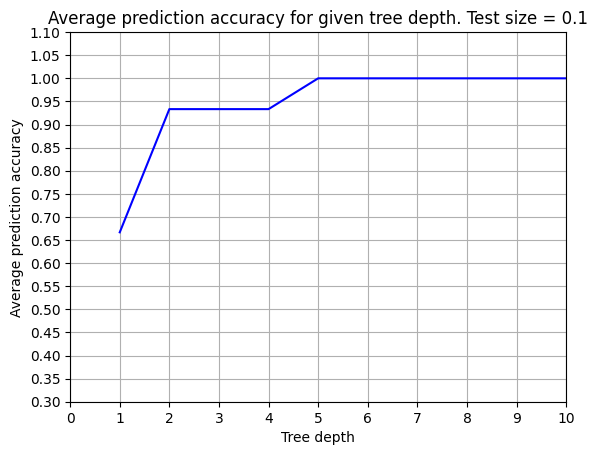

In [145]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

train_group = Group(y_train, x_train)
tree_max_depths = [_ for _ in range(1, 11)]

accuracy = []
for tree_max_depth in tree_max_depths:
    dc = DecisionTreeClassifier(tree_max_depth)
    dc.build_tree(train_group)
    correct_predictions = 0
    for sample, gt in zip(x_test, y_test):
        prediction = dc.predict(sample)
        if prediction == gt:
            correct_predictions += 1
    # print(correct_predictions)
    accuracy.append(correct_predictions / len(y_test))

# print(len(y_test))
make_graph(tree_max_depths, accuracy, "0.1")


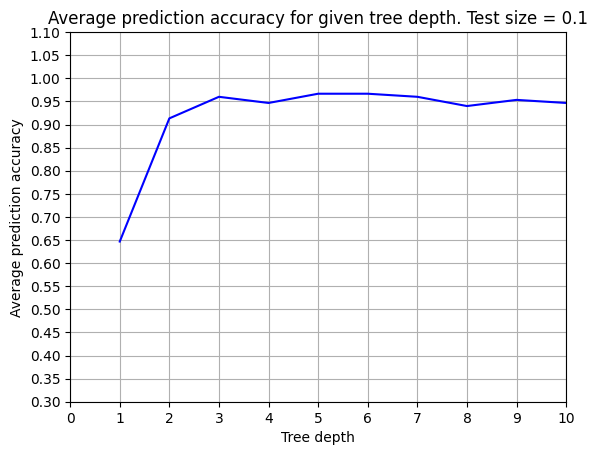

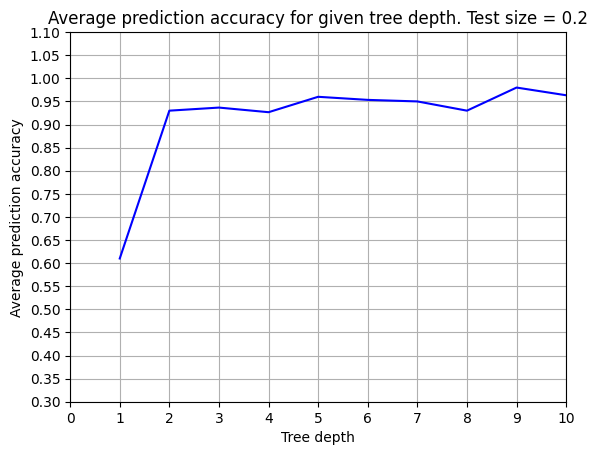

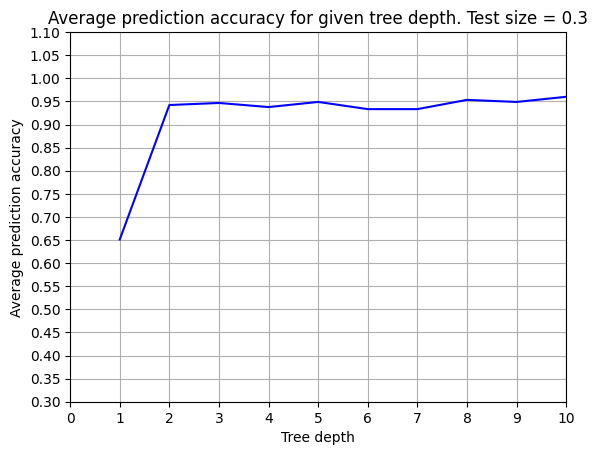

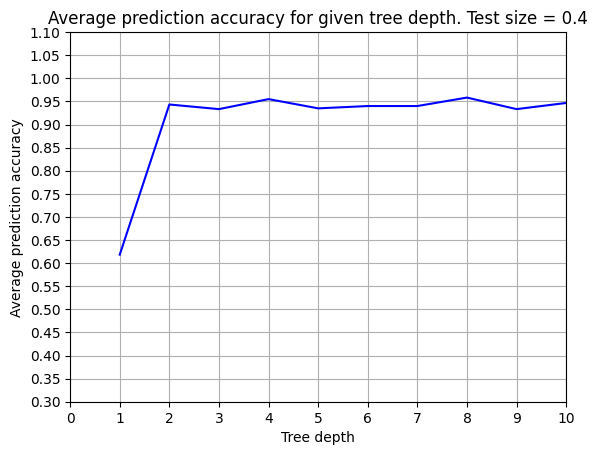

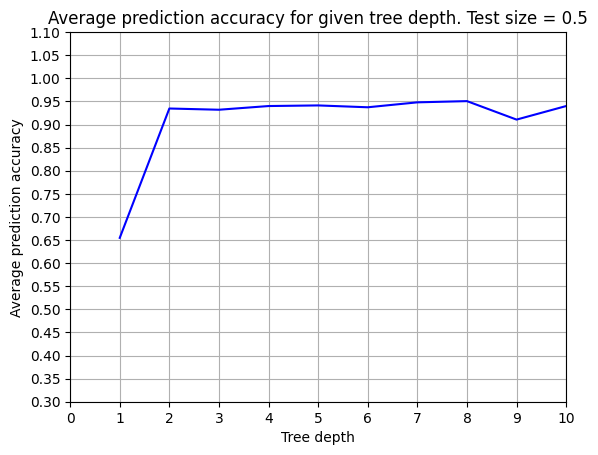

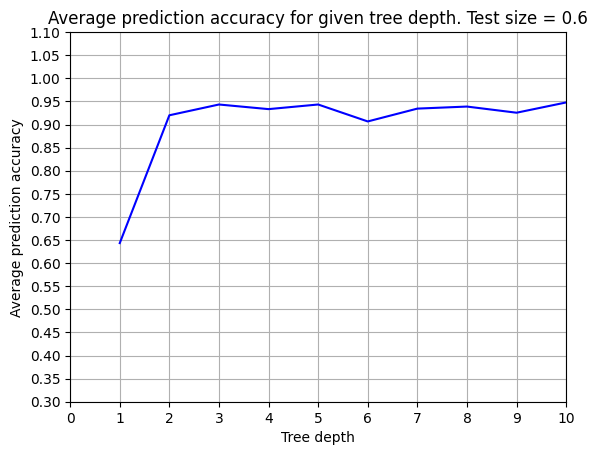

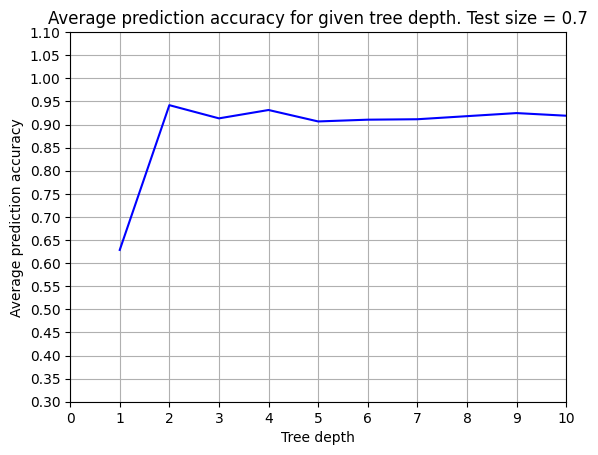

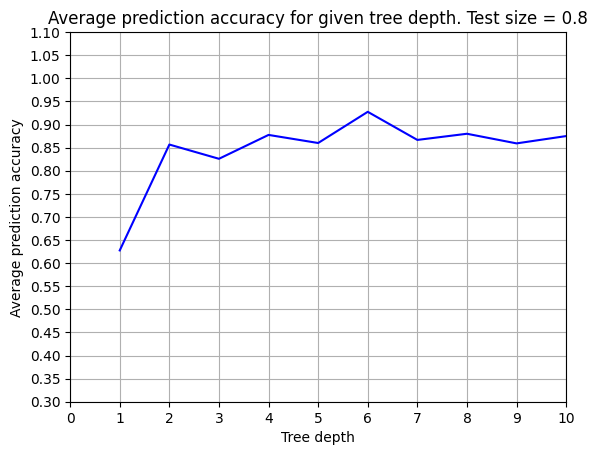

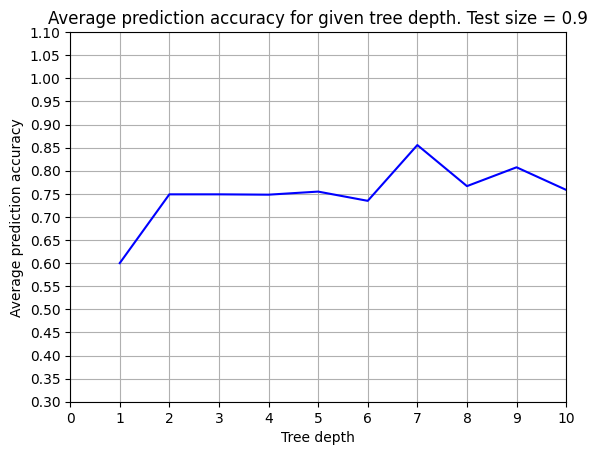

In [146]:
# testing for parameters: test_size = 0.1, random_state = 123, tree depth in [1, 10]
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]



for test_size in test_sizes:
    tree_max_depths = [_ for _ in range(1, 11)]
    average_accuracy = []
    for tree_max_depth in tree_max_depths:
        accuracy_units = []
        for _ in range(10):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

            dc = DecisionTreeClassifier(tree_max_depth)
            train_group = Group(y_train, x_train)
            dc.build_tree(train_group)

            correct_predictions = 0
            for sample, gt in zip(x_test, y_test):
                prediction = dc.predict(sample)
                if prediction == gt:
                    correct_predictions += 1

            # print(correct_predictions)
            accuracy_units.append(correct_predictions / len(y_test))
        average_accuracy.append(sum(accuracy_units) / len(accuracy_units))
        # print(sum(accuracy_units) / len(accuracy_units))

    make_graph(tree_max_depths, average_accuracy, str(test_size))

Stosunek danych testowych do treningowych:

Im większa jest ilość danych treningowych w stosunku do testowych, tym większa jest szansa na to, że drzewo zostanie skonstruowane w taki sposób, który z więszką poprawnością będzie mógł wyznaczać klasy danych testowych. Dzieje się tak, gdyż przy dużej ilości danych testowych, algorytmowi łatwiej jest "wyłapać" trendy danych.

Głębokość drzewa:

Do momentu prawie pełnego zapełnienia drzea, jego głębokość ma znaczenie, tj. większe drzewo pozwala na lepszą analizę danych i minimalizuje ewentualne ucinanie. Natomiast po osiągnięciu głębokości maksymalnej powyżej której mieści się większość danych, zwiększenie głębokości przynosi minimalne lub zerowe korzyści gdyż, wzrost liczby danych mieszących się w drzewie jest bardzo niewielki.

Problemy:

Czasami zbyt głębokie drzewo może prowadzić do "przeuczenia", tj. przewidywania kategorii danych na podstawie pojedynczych przypadków, a nie tredów w ogóle danych. Może to też spowodować błędne przewidywania, ze wzlędu na istnienie szumów lub anomalii w danych treningowych, które dla drzewa o dużej głębokości są równie istotne jak regularne dane.